# 投资者情绪专题
在短暂的学习生涯中,窥见了学术前沿中一些令人兴奋的领域...这使我如此渴望接触更大的世界,在研究中"讲好中国故事"!

## 1.数据准备

In [1]:
import sys
import os
import cudf  #CUDA计算
import pandas as pd
import numpy as np

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')
from loader.findata_loader import Loader
from utils.sql import DB

# Stata
from pystata import config  # noqa

config.init('mp')
# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


### 媒体情绪数据

In [2]:
def extract_pdate_mediasent() -> cudf.DataFrame:
    """
    提取推文中的情绪,自然日期
    :return:
    """
    # 提取
    pd.options.mode.chained_assignment = None  #忽略警告
    df_select = pd.read_sql(
            "SELECT id,p_date, title_neg, cover_neg, biz FROM WECAHT_DATA.articles_tag "
            "WHERE mov=10 AND biz in ('MjM5MzMwNjM0MA==','MjM5NzQ5MTkyMA==','MjY2NzgwMjU0MA==','MjY2NzgwMjU0MA==')",
            con=DB().ENGINE,
            parse_dates=["p_date"])

    # 筛选
    df_select['p_date'] = df_select['p_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_select = df_select.query("p_date>=20140101")

    # 阈值处理
    df_select['title_flag'] = df_select['title_neg'].apply(lambda x: 1 if x > 0.5 else 0)
    df_select['cover_flag'] = df_select['cover_neg'].apply(lambda x: 1 if x > 0.5 else 0)

    # 每日情绪
    df_select['day_article'] = df_select.groupby('p_date')['id'].transform('count')

    df_select['tex_neg'] = df_select['title_flag'] / df_select['day_article']
    df_select['img_neg'] = df_select['cover_flag'] / df_select['day_article']

    # 时间序列
    df_select = df_select.groupby(['p_date', ], as_index=False).first()
    # 筛选
    return cudf.from_pandas(df_select[['p_date', 'img_neg', 'tex_neg']]).set_index('p_date').sort_index().reset_index()


extract_pdate_mediasent()

,p_date,img_neg,tex_neg
0,20140101,0.0,0.000000
1,20140102,0.0,0.000000
2,20140103,0.0,0.333333
3,20140104,0.0,0.000000
4,20140105,0.0,0.000000
...,...,...,...
3069,20220623,0.0,0.000000
3070,20220624,0.0,0.142857
3071,20220625,0.0,0.000000
3072,20220626,0.0,0.000000


### 股吧情绪数据

In [3]:
df_forum = (
        cudf.read_parquet(
                DATASETS_PATH + 'FORUM_SENT_TRANS.parquet',
                columns=['PostDate', 'Stockcode', 'PostSource', 'PositiveSentIndexA', 'PositiveSentIndexB',
                         'PositivePosts', 'NeutralPosts', 'NegativePosts',
                         'TotalPosts', 'AvgReadings', 'AvgComments', 'AvgThumbUps',
                         'AvgUserBarAge'])
        .rename(columns={'TotalPosts': 'CumPosts', 'PostDate': 'p_date'})
        .astype(dtype={'PositivePosts': 'float64', 'NeutralPosts': 'float64', 'NegativePosts': 'float64'})
        .query("p_date>=20140101")
)

#
df_forum.set_index(['p_date', 'Stockcode']).sort_index()

PostSource PositiveSentIndexA PositiveSentIndexB  \
p_date   Stockcode                                                     
20140101 000030.SZ           1               <NA>               <NA>   
         000030.SZ           1               <NA>               <NA>   
         000034.SZ           1               <NA>               <NA>   
         000034.SZ           1               <NA>               <NA>   
         000043.SZ           1               <NA>               <NA>   
...                        ...                ...                ...   
20211016 900948.SH           1               <NA>               <NA>   
         900952.SH           1               <NA>               <NA>   
         900953.SH           1               <NA>               <NA>   
         900955.SH           1               <NA>               <NA>   
         900957.SH           1               <NA>               <NA>   

                   PositivePosts  NeutralPosts NegativePosts  CumPosts  \
p_date   Stockcode                                                       
20140101 000030.SZ           0.0           0.0           0.0         0   
         000030.SZ          <NA>           0.0          <NA>         0   
         000034.SZ           0.0           0.0           0.0         0   
         000034.SZ          <NA>           0.0          <NA>         0   
         000043.SZ           0.0           0.0           0.0         0   
...                          ...           ...           ...       ...   
20211016 900948.SH           0.0           0.0           0.0         0   
         900952.SH           0.0           0.0           0.0         0   
         900953.SH           0.0           0.0           0.0         0   
         900955.SH           0.0           0.0           0.0         0   
         900957.SH           0.0           0.0           0.0         0   

                   AvgReadings AvgComments AvgThumbUps AvgUserBarAge  
p_date   Stockcode                                                    
20140101 000030.SZ        <NA>        <NA>        <NA>          <NA>  
         000030.SZ        <NA>        <NA>        <NA>          <NA>  
         000034.SZ        <NA>        <NA>        <NA>          <NA>  
         000034.SZ        <NA>        <NA>        <NA>          <NA>  
         000043.SZ        <NA>        <NA>        <NA>          <NA>  
...                        ...         ...         ...           ...  
20211016 900948.SH        <NA>        <NA>        <NA>          <NA>  
         900952.SH        <NA>        <NA>        <NA>          <NA>  
         900953.SH        <NA>        <NA>        <NA>          <NA>  
         900955.SH        <NA>        <NA>        <NA>          <NA>  
         900957.SH        <NA>        <NA>        <NA>          <NA>  

[11846133 rows x 11 columns]

### 日期映射

In [4]:
def extract_map_date() -> cudf.DataFrame:
    df_mapdate = pd.read_sql_table('map_date', DB().ENGINE, 'FIN_BASIC', parse_dates=['nature_date', 'map_l0'])[
        ['nature_date', 'map_l0', 'map_l1']]
    df_mapdate['nature_date'] = df_mapdate['nature_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_mapdate.dropna(axis=0, subset=['map_l0'], inplace=True)
    df_mapdate['map_l0'] = df_mapdate['map_l0'].dt.strftime('%Y%m%d').astype('uint32')
    return cudf.from_pandas(df_mapdate.rename(columns={'nature_date': 'p_date', 'map_l0': 'trade_date', 'map_l1': 'trade_date_l1'}))


extract_map_date()

,p_date,trade_date,trade_date_l1
0,20140101,20140102,2014-01-02 00:00:00.000000000
1,20140102,20140102,2014-01-03 00:00:00.000000000
2,20140103,20140103,2014-01-06 00:00:00.000000000
3,20140104,20140106,2014-01-06 00:00:00.000000000
4,20140105,20140106,2014-01-06 00:00:00.000000000
...,...,...,...
3235,20221110,20221110,2022-11-11 00:00:00.000000000
3236,20221111,20221111,2022-11-14 00:00:00.000000000
3237,20221112,20221114,2022-11-14 00:00:00.000000000
3238,20221113,20221114,2022-11-14 00:00:00.000000000


### 指数面板数据

In [5]:
df_basic = cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_BASIC_WUGUI.parquet')[['close']].query("trade_date>=20131231").reset_index()
df_basic['close_l1'] = df_basic.groupby(by=['ts_code'], as_index=False, sort=True)['close'].shift(1)
df_basic['close_chg'] = 100 * ((df_basic['close'] / df_basic['close_l1']) - 1)
df_basic['time'] = df_basic.groupby(by=['ts_code'])['trade_date'].rank()
df_basic

,trade_date,ts_code,close,close_l1,close_chg,time
0,20131231,000001.SH,2115.9800,<NA>,<NA>,1.0
1,20131231,000010.SH,5040.2700,<NA>,<NA>,1.0
2,20131231,000015.SH,1681.4600,<NA>,<NA>,1.0
3,20131231,000016.SH,1574.7800,<NA>,<NA>,1.0
4,20131231,000300.SH,2330.0300,<NA>,<NA>,1.0
...,...,...,...,...,...,...
28251,20221209,000985.SH,4973.3481,4947.6296,0.519814579,2172.0
28252,20221209,399001.SZ,11501.5800,11389.79,0.981493074,2175.0
28253,20221209,399005.SZ,7674.1500,7610.6,0.835019578,2175.0
28254,20221209,399006.SZ,2420.6300,2411.81,0.365700449,2175.0


## 2.投资者情绪指标计算

计算加权影响力,参数为影响力系数,点赞评论阅读

In [6]:
# 5311 5%A 10%B
# 1000 9100  X
# 1000 X

# pdate
# A, B, C, D = 0.6, 0.2, 0.1, 0.1
A, B, C, D = 1.0, 0.0, 0.0, 0.0
# A, B, C, D = 0.0, 1.0, 0.0, 0.0
# tdate
A2, B2, C2, D2 = 0.6, 0.2, 0.1, 0.1

### 发布日情绪

In [7]:

def cal_investor_sentiment_pdate() -> pd.DataFrame:
    """
    从论坛面板原始数据中,合并映射日期,并进行聚合
    :return:
    """
    # 映射,多了一列trade_date
    df_forum_panel = (
            cudf.merge(
                    df_forum, extract_map_date(), on='p_date', how='left')
            .query("PostSource==1")
    )
    # 去重
    df_forum_panel = df_forum_panel.groupby(['p_date', 'Stockcode']).first().reset_index()

    # 计算每日总量
    # NeutralPosts
    # df_forum_panel.eval(
    #         """
    #         TotalPosts = PositivePosts+NeutralPosts+NegativePosts
    #         """, inplace=True)
    # return df_forum_panel
    df_forum_panel.eval(
            """
            TotalPosts = PositivePosts+NeutralPosts+NegativePosts
            TotalReadings = AvgReadings*TotalPosts
            TotalComments = AvgComments*TotalPosts
            TotalThumbUps = AvgThumbUps*TotalPosts
            """, inplace=True)

    # 汇总每天的注意力数据,以计算每只股票的权重因子
    for col in ['AvgUserBarAge',
                'TotalPosts', 'TotalReadings', 'TotalComments', 'TotalThumbUps',
                'PositivePosts', 'NeutralPosts', 'NegativePosts']:
        # 年龄
        if col == 'AvgUserBarAge': df_forum_panel['day' + col] = df_forum_panel.groupby(['p_date'])[col].transform('mean')
        # 注意力 + 帖子
        else: df_forum_panel['day' + col] = df_forum_panel.groupby(['p_date'])[col].transform('sum')

    # 计算权重因子
    df_forum_panel.eval(
            f"""
            factorPositiveSentIndexA = PositiveSentIndexA * ({A}*(TotalPosts/dayTotalPosts)+ {B}*(TotalReadings/dayTotalReadings)+{C}*(TotalComments/dayTotalComments) + {D}*(TotalThumbUps/dayTotalThumbUps))
            factorPositiveSentIndexB = PositiveSentIndexB * ({A}*(TotalPosts/dayTotalPosts)+ {B}*(TotalReadings/dayTotalReadings)+{C}*(TotalComments/dayTotalComments) + {D}*(TotalThumbUps/dayTotalThumbUps))

            dayPosRatio = dayPositivePosts/dayTotalPosts
            dayNeuRatio = dayNeutralPosts/dayTotalPosts
            dayNegRatio = dayNegativePosts/dayTotalPosts

            """, inplace=True)

    # 计算每日情绪
    df_forum_panel['SentIndexA'] = df_forum_panel.groupby(['p_date'])['factorPositiveSentIndexA'].transform('sum')
    df_forum_panel['SentIndexB'] = df_forum_panel.groupby(['p_date'])['factorPositiveSentIndexB'].transform('sum')

    # 时间序列数据
    df_forum_panel = df_forum_panel.groupby(['p_date']).first()[
        ['SentIndexA', 'SentIndexB',
         'dayAvgUserBarAge',
         'dayTotalPosts', 'dayTotalReadings', 'dayTotalComments', 'dayTotalThumbUps',
         'dayPositivePosts', 'dayNeutralPosts', 'dayNegativePosts',
         'dayPosRatio', 'dayNeuRatio', 'dayNegRatio',
         ]].reset_index()

    df_forum_panel.columns = ['p_date',
                              'IndexA', 'IndexB',
                              'Age', 'Posts', 'Readings', 'Comments', 'ThumbUps',
                              'PosPosts', 'NeuPosts', 'NegPosts',
                              'PosRatio', 'NeuRatio', 'NegRatio', ]
    # 计算每日指标

    # 合并媒体情绪
    df_merge = cudf.merge(extract_pdate_mediasent(), df_forum_panel, on='p_date', how='left')

    # 单位
    # df_merge['Readings'] = df_merge['Readings'] / 100
    return df_merge.set_index('p_date').sort_index().reset_index().to_pandas().astype(dtype={'p_date': 'str'})


cal_investor_sentiment_pdate()
# @formatter:off

,p_date,img_neg,tex_neg,IndexA,IndexB,Age,Posts,Readings,Comments,ThumbUps,PosPosts,NeuPosts,NegPosts,PosRatio,NeuRatio,NegRatio
0,20140101,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,20140102,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2,20140103,0.0,0.333333,0.0,0.0,0.095,2.0,107379.0,342.0,2.0,1.0,0.0,1.0,0.5,0.0,0.5
3,20140104,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
4,20140105,0.0,0.000000,NaN,NaN,0.000,1.0,9694.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,20220623,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3070,20220624,0.0,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3071,20220625,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,20220626,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 自然日情绪(旧)

In [8]:
def cal_investor_sentiment(df: cudf.DataFrame, a, b, c, d) -> cudf.DataFrame:
    """
    计算加权投资者情绪
    :return:
    """

    # 每日总量
    df['DayTotalPosts'] = df.groupby(['PostDate', ])['TotalPosts'].transform('sum')
    df['DayAvgReadings'] = df.groupby(['PostDate', ])['AvgReadings'].transform('sum')
    df['DayAvgComments'] = df.groupby(['PostDate', ])['AvgComments'].transform('sum')
    df['DayAvgPositThumbUps'] = df.groupby(['PostDate', ])['AvgPositThumbUps'].transform('sum')

    # 加权因子总量
    df['DayTotalPostsFactor'] = df['TotalPosts'] / df['DayTotalPosts']
    df['DayAvgReadingsFactor'] = df['AvgReadings'] / df['DayAvgReadings']
    df['DayAvgCommentsFactor'] = df['AvgComments'] / df['DayAvgComments']
    df['DayAvgPositThumbUpsFactor'] = df['AvgPositThumbUps'] / df['DayAvgPositThumbUps']

    # 个股加权情绪因子
    df['PositiveSentIndexAFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexA']
    )

    df['PositiveSentIndexBFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexB']
    )

    # 每日情绪因子
    df['DayPositiveSentIndexA'] = df.groupby(['PostDate'])['PositiveSentIndexAFactor'].transform('sum')
    df['DayPositiveSentIndexB'] = df.groupby(['PostDate'])['PositiveSentIndexBFactor'].transform('sum')

    # 转换为时间序列数据
    df_time = df.groupby(['PostDate', ], as_index=False).first()[
        ['PostDate', 'DayPositiveSentIndexA', 'DayPositiveSentIndexB',
         'DayTotalPosts', 'DayAvgReadings', 'DayAvgComments', 'DayAvgPositThumbUps']]
    df_time.columns = ['p_date', 'IndexA', 'IndexB', 'Posts', 'Readings', 'Comments', 'ThumbUps']
    return df_time

# cal_investor_sentiment(df_forum, A, B, C, D)

### 合并和映射

In [9]:
def merge_tdate_media_investor_ex(ex_coff) -> cudf.DataFrame:
    """
    考虑了衰减系数
    :return:
    """
    df_map = cudf.merge(
            cal_investor_sentiment(df_forum, A2, B2, C2, D2),
            extract_map_date(),
            on=['p_date'], how='left'

    ).set_index(['trade_date', 'p_date']).sort_index().reset_index()

    # 计算序号
    df_map['distance'] = df_map.groupby('trade_date')['p_date'].rank()

    # 指数化衰减
    df_map['distance_ex'] = np.exp(df_map['distance'] / ex_coff)
    df_map['ex_total'] = df_map.groupby('trade_date')['distance_ex'].transform('sum')
    df_map['ex_factor'] = df_map['distance_ex'] / df_map['ex_total']

    # 衰减
    df_map = df_map.set_index(['trade_date', 'p_date'])
    for col in df_map.columns: df_map[col] = df_map[col] * df_map['ex_factor']
    df_map = df_map.reset_index()

    # 计算平均指标 这里应该要衰减
    df_map['IndexA'] = df_map.groupby('trade_date', as_index=False)['IndexA'].transform('mean')
    df_map['IndexB'] = df_map.groupby('trade_date', as_index=False)['IndexB'].transform('mean')
    df_map['Posts'] = df_map.groupby('trade_date', as_index=False)['Posts'].transform('mean')
    df_map['Readings'] = df_map.groupby('trade_date', as_index=False)['Readings'].transform('mean')
    df_map['Comments'] = df_map.groupby('trade_date', as_index=False)['Comments'].transform('mean')
    df_map['ThumbUps'] = df_map.groupby('trade_date', as_index=False)['ThumbUps'].transform('mean')

    # 时间序列
    df_map = df_map.groupby('trade_date').first().sort_index().reset_index()

    # 合并
    df_merge = cudf.merge(Loader().get_time_series().reset_index(), df_map, on='trade_date', how='left')

    # 单位
    df_merge['Readings'] = df_merge['Readings'] / 100

    return df_merge.set_index('trade_date').sort_index().reset_index()


def merge_tdate_media_investor() -> cudf.DataFrame:
    """
    合并论坛和媒体情绪,交易日期
    """
    df_map = cudf.merge(
            cal_investor_sentiment(df_forum, A2, B2, C2, D2),
            extract_map_date(),
            on=['p_date'], how='left'

    )

    # 计算平均指标 这里应该要衰减
    df_map['IndexA'] = df_map.groupby('trade_date', as_index=False)['IndexA'].transform('mean')
    df_map['IndexB'] = df_map.groupby('trade_date', as_index=False)['IndexB'].transform('mean')
    df_map['Posts'] = df_map.groupby('trade_date', as_index=False)['Posts'].transform('mean')
    df_map['Readings'] = df_map.groupby('trade_date', as_index=False)['Readings'].transform('mean')
    df_map['Comments'] = df_map.groupby('trade_date', as_index=False)['Comments'].transform('mean')
    df_map['ThumbUps'] = df_map.groupby('trade_date', as_index=False)['ThumbUps'].transform('mean')

    # 时间序列
    df_map = df_map.groupby('trade_date').first().sort_index().reset_index()

    # 合并
    df_merge = cudf.merge(Loader().get_time_series().reset_index(), df_map, on='trade_date', how='left')

    # 单位
    df_merge['Readings'] = df_merge['Readings'] / 100

    return df_merge.set_index('trade_date').sort_index().reset_index()


def merge_pdate_media_investor() -> cudf.DataFrame:
    """
    发布日期定义的合并
    :return:
    """
    # 合并
    df_merge = cudf.merge(extract_pdate_mediasent(), cal_investor_sentiment(df_forum, A, B, C, D), on='p_date',
                          how='left')
    # 单位
    df_merge['Readings'] = df_merge['Readings'] / 100

    # 改名字方便变量
    return df_merge.rename(columns={'p_date': 'trade_date'}).set_index('trade_date').sort_index().reset_index()



In [10]:
# df_var = (
#         cudf.merge(
#                 df_basic,
#                 (cudf.merge(cudf.from_pandas(extract_pdate_wcsentiment()),
#                             cal_investor_sentiment(df_forum, A, B, C, D),
#                             on='trade_date', how='left')),
#                 on='trade_date', how='left'
#         )
#
# )
# df_var = df_var.to_pandas().astype(dtype={'trade_date': 'str'}).sort_values('trade_date')
# df_var

In [11]:
# 交易日期和自然日期
df_ols_pdate = cal_investor_sentiment_pdate()
# df_ols_tdate = merge_tdate_media_investor()
# //df_ols_tdate = merge_tdate_media_investor()

# 调整格式
# df_ols_tdate = df_ols_tdate.to_pandas().astype(dtype={'trade_date': 'str'}).sort_values('trade_date')
df_ols_pdate

,p_date,img_neg,tex_neg,IndexA,IndexB,Age,Posts,Readings,Comments,ThumbUps,PosPosts,NeuPosts,NegPosts,PosRatio,NeuRatio,NegRatio
0,20140101,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,20140102,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2,20140103,0.0,0.333333,0.0,0.0,0.095,2.0,107379.0,342.0,2.0,1.0,0.0,1.0,0.5,0.0,0.5
3,20140104,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
4,20140105,0.0,0.000000,NaN,NaN,0.000,1.0,9694.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,20220623,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3070,20220624,0.0,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3071,20220625,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,20220626,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 描述性统计

In [12]:
# @formatter:off

In [51]:
%%stata -d df_ols_pdate -force
sum Age,detail


                             Age
-------------------------------------------------------------
      Percentiles      Smallest
 1%          .03          -2.83
 5%          .74          -2.79
10%        1.274           -.99       Obs               2,586
25%      2.38375              0       Sum of wgt.       2,586

50%     3.151351                      Mean           3.044093
                        Largest       Std. dev.      1.285657
75%     3.611364           8.38
90%     4.543333           8.44       Variance       1.652915
95%     4.921725           8.81       Skewness       .1316103
99%      7.10403           9.46       Kurtosis       4.699403


In [54]:
%%stata -d df_ols_pdate -force -gw 12in -gh 6in  -qui -nogr

//设定时间序列
ge dt = date(p_date, "YMD")
ge year=year(dt)
format dt %tdCCYYNNDD
tsset dt


//绘制股吧数据变化图
graph drop _all
foreach var in Posts Readings Comments ThumbUps Age   {
    winsor2 `var', cut(0 99) trim replace
    twoway (tsline `var' ,lwidth(vvvthin)) ,name(`var',replace) xtitle("")  ylabel(, nogrid) scheme(sj) xsize(10)
}

//投资者情绪折线图
twoway (tsline IndexB )  ,name(time_change,replace) ///
xtitle(Date,margin(medium)) xlabel(, labgap(medium)) ///
ytitle(Investor Sentiment) ylabel(, nogrid) scheme(sj)

//投资者情绪分布图
histogram IndexB, name(distribution,replace) ///
xtitle(Investor Sentiment,margin(medium)) xlabel(, labgap(medium)) ///
ylabel(, nogrid)  scheme(sj) ///
normal normopts(lpattern(dash))


. histogram Age, name(distribution,replace) ///
> xtitle(Investor Sentiment,margin(medium)) xlabel(, labgap(medium)) ///
> ylabel(, nogrid)  scheme(sj) ///
> normal normopts(lpattern(dash))
(bin=34, start=-2.83, width=.29217734)

. 


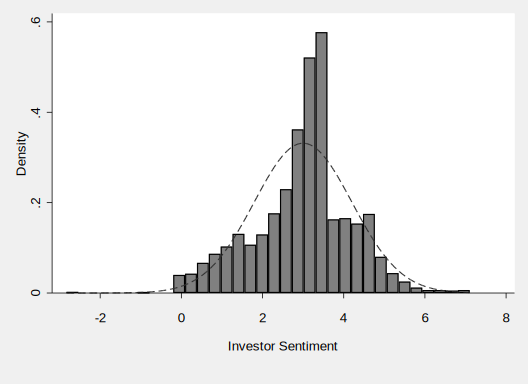

In [15]:
%%stata
histogram Age, name(distribution,replace) ///
xtitle(Investor Sentiment,margin(medium)) xlabel(, labgap(medium)) ///
ylabel(, nogrid)  scheme(sj) ///
normal normopts(lpattern(dash))

图片合成

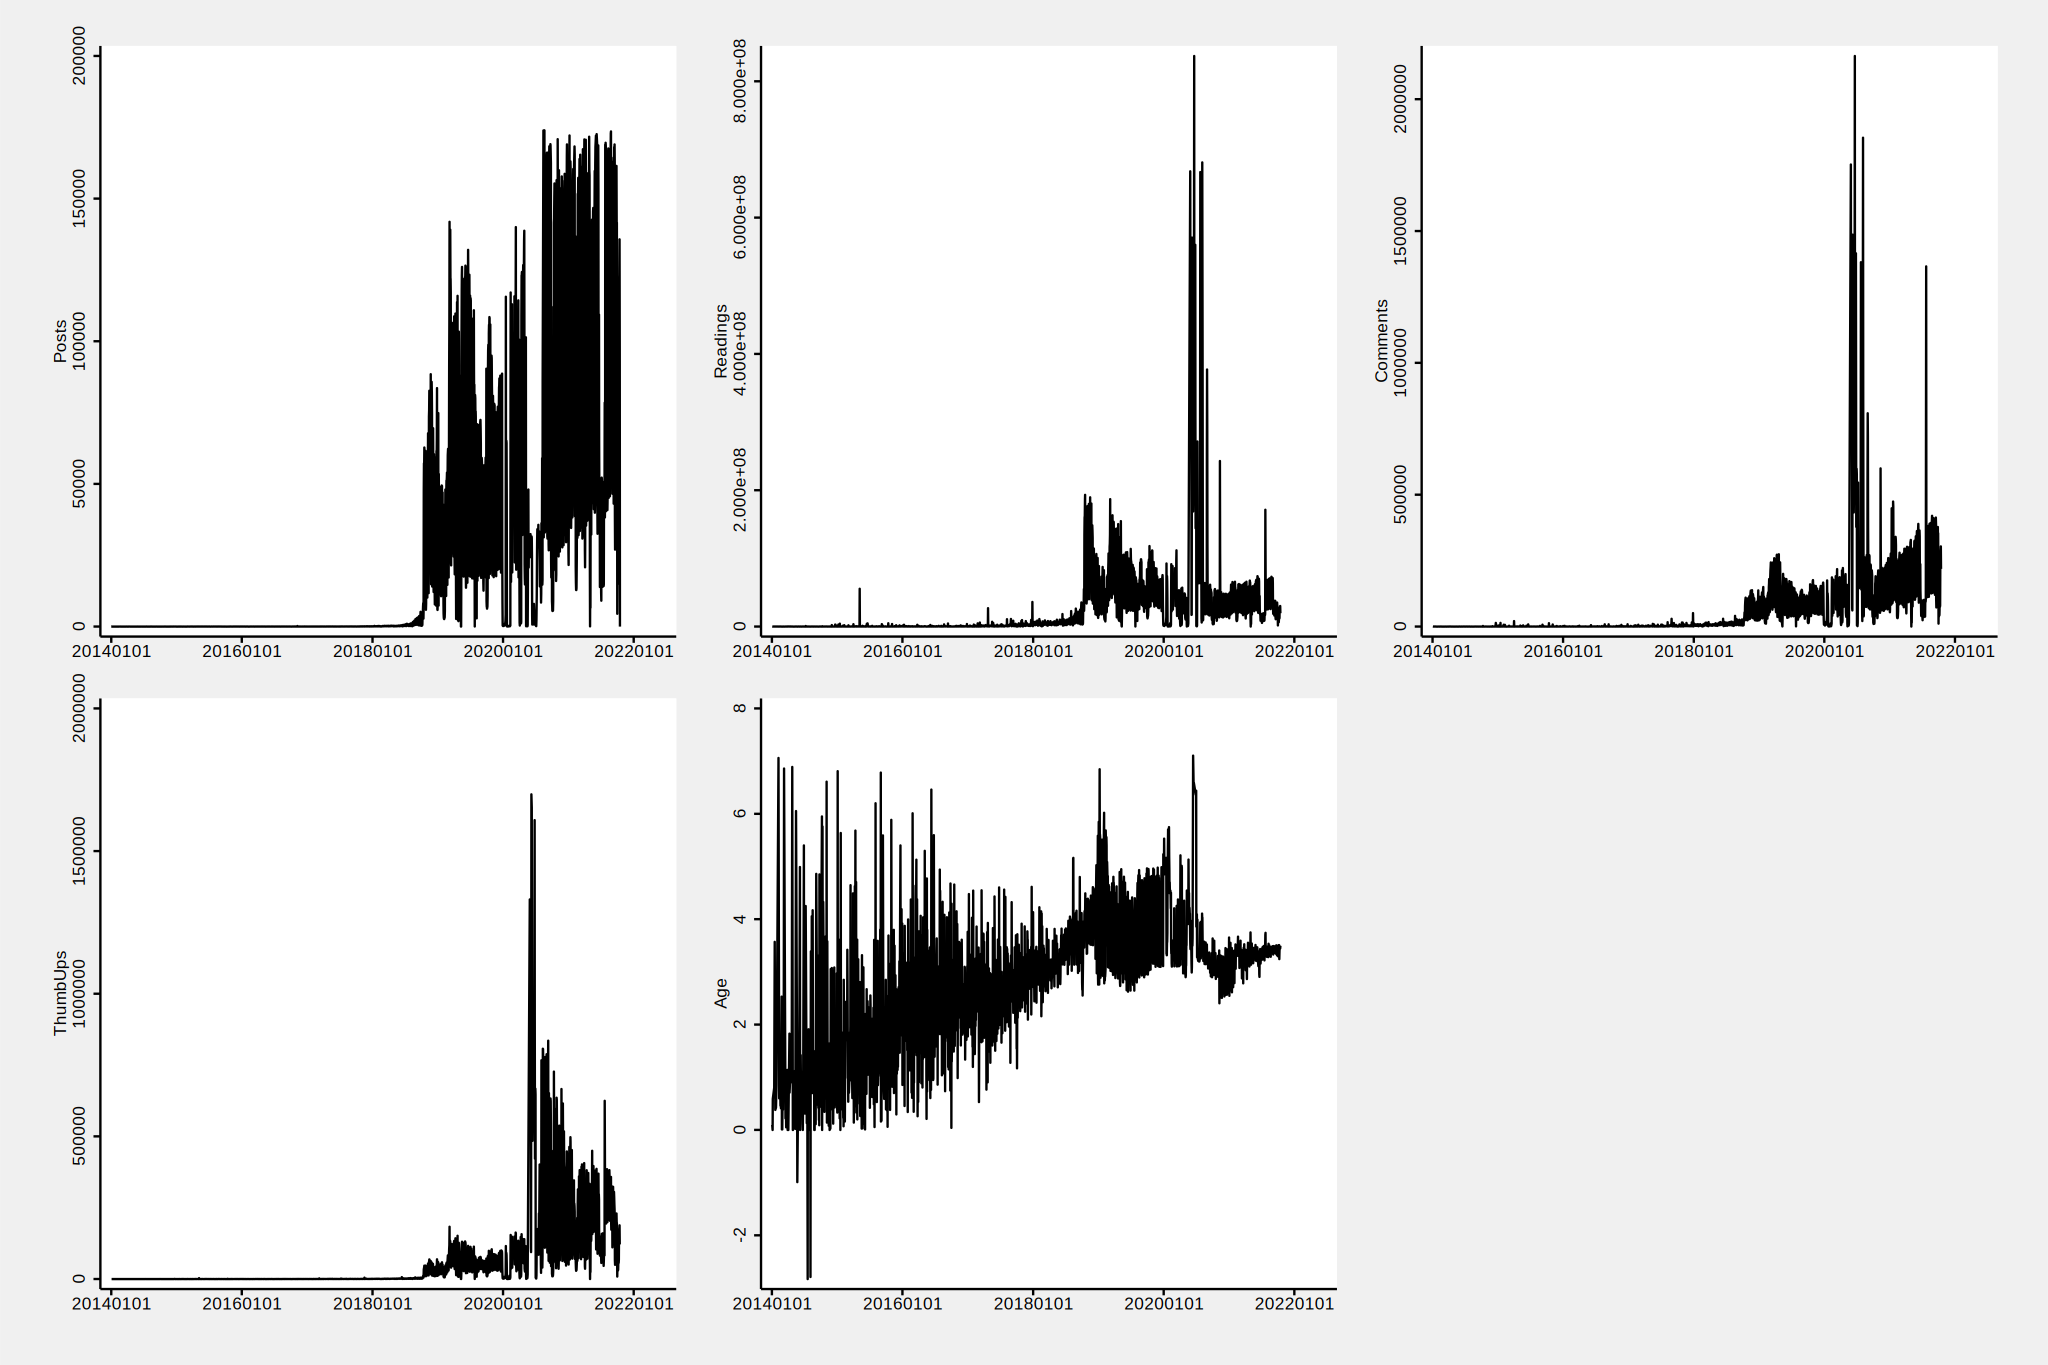

In [16]:
%%stata  -gw 12in -gh 8in
graph combine Posts Readings Comments ThumbUps Age, name(c1,replace)  scale(0.5) scheme(sj)

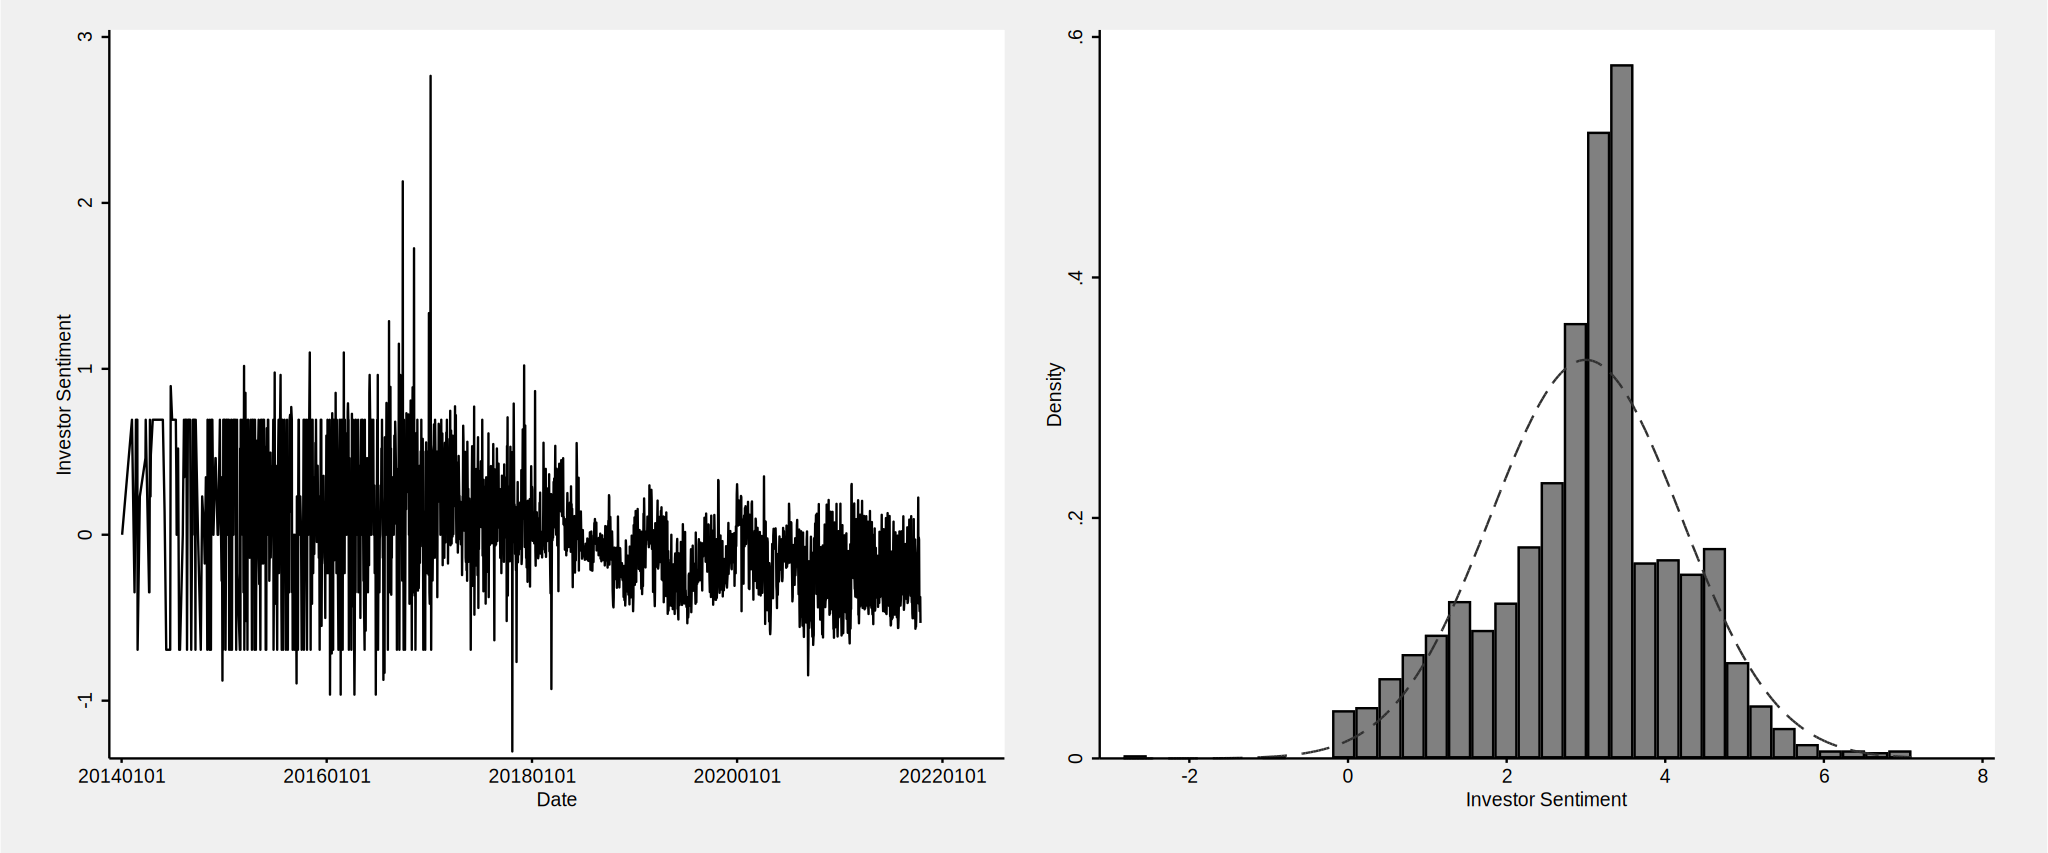

In [17]:
%%stata -gw 12in -gh 5in
graph combine time_change distribution, name(c2,replace) scale(0.5)  scheme(sj)

## 3.媒体情绪对投资者情绪的影响

### 线性回归分析-发布日期

#### 模型设定

In [55]:
%%stata -d df_ols_pdate -force -qui
//设定时间序列
ge time=_n
tsset time

//缩尾
winsor2 Age IndexA IndexB, cut(1 99)  replace
winsor2 Age, cut(1 100) trim replace

//外生变量
ge dt = date(p_date, "YMD")
format dt %tdCCYYNNDD
ge year=year(dt)


//变量对数处理
ge NonNegRatio=1-NegRatio
foreach var in Posts Readings Comments ThumbUps NegPosts NeuPosts PosPosts {
    ge ln`var'=ln(`var')
}

#### 基准回归

In [19]:
%%stata

//清除
est clear

//图像情绪回归
rename(img_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (img_neg)

//文本情绪回归
rename(tex_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (tex_neg)

//增加固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_base ,r type ///
keep(L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSent B" "InvestorSent A" "InvestorSent B") ///
mgroups("img_neg" "tex_neg", pattern(1 0 1 0 )) ///
nogaps  b(%12.4f)


. 
. //清除
. est clear

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est1 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est2 stored)

. rename(media_neg) (img_neg)

. 
. //文本情绪回归
. rename(tex_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est3 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est4 stored)

. rename(media_neg) (tex_neg)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_base ,r type ///
> keep(L.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSen
> t B" "InvestorSent A" "InvestorSent B") ///
> mgroups

#### 注意力效应回归
媒体情绪通过投资者关注度,影响投资者情绪

In [20]:
%%stata
//清除
est clear

//图像情绪回归
eststo: qui reg IndexB L.lnPosts L.img_neg i.year ,r
eststo: qui reg IndexB L.lnPosts c.L.lnReadings#c.L.img_neg i.year,r
eststo: qui reg IndexB L.lnPosts c.L.lnComments#c.L.img_neg i.year,r
eststo: qui reg IndexB L.lnPosts c.L.lnThumbUps#c.L.img_neg i.year,r

//增加固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_inter ,r type ///
keep(*L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table Investor Attention") ///
nogaps compress b(%12.4f)


. //清除
. est clear

. 
. //图像情绪回归
. eststo: qui reg IndexB L.lnPosts L.img_neg i.year ,r
(est1 stored)

. eststo: qui reg IndexB L.lnPosts c.L.lnReadings#c.L.img_neg i.year,r
(est2 stored)

. eststo: qui reg IndexB L.lnPosts c.L.lnComments#c.L.img_neg i.year,r
(est3 stored)

. eststo: qui reg IndexB L.lnPosts c.L.lnThumbUps#c.L.img_neg i.year,r
(est4 stored)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_inter ,r type ///
> keep(*L.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table Investor Attention") ///
> nogaps compress b(%12.4f)

Table Investor Attention
--------------------------------------------------------------
                 (1)          (2)          (3)          (4)   
              IndexB       IndexB       IndexB       IndexB   
--------------------------------------------------------------
L.lnPosts    -0.0469***   -0.0465***   -0.0463***   

#### 情绪非对称效应回归

In [38]:
%%stata
//清除
est clear

//图像情绪回归 积极,消极和中立的异质影响
eststo: qui reg IndexB L.lnPosts L.img_neg  i.year ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio  i.year ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.PosRatio  i.year ,r

//增加固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_nonsymmetry ,r type ///
keep(*L*.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table Investor Non-symmetry") ///
nogaps b(%12.4f)


. //清除
. est clear

. 
. //图像情绪回归 积极,消极和中立的异质影响
. eststo: qui reg IndexB L.lnPosts L.img_neg  i.year ,r
(est1 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio  i.year ,r
(est2 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.PosRatio  i.year ,r
(est3 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio c.L.img_neg#c.L.Non
> NegRatio  i.year ,r
(est4 stored)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_nonsymmetry ,r type
>  ///
> keep(*L*.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table Investor Non-symmetry") ///
> nogaps b(%12.4f)

Table Investor Non-symmetry
----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                   IndexB          IndexB          IndexB          IndexB   
--------------------

#### 年龄异质性回归

In [67]:
%%stata
//清除
est clear

//图像情绪回归 按年龄分组
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts  i.year if Age<3.151351 ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio  i.year if Age<3.151351 ,r

eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts i.year if Age>=3.151351 ,r
eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio i.year if Age>=3.151351 ,r



//增加固定效应
estadd local Year "Yes" : *

//输出回归结果
esttab using Investor-Sentiment/outputs/media_to_investor_age ,r type ///
keep(*L*.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table Investor Age") ///
mgroups("Low Age" "High Age", pattern(1 0 1 0 )) ///
nogaps b(%12.4f)


. //清除
. est clear

. 
. //图像情绪回归 按年龄分组
. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts  i.year if Age<3.151
> 351 ,r
(est1 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio  i.year if Age<3.15
> 1351 ,r
(est2 stored)

. 
. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.lnPosts i.year if Age>=3.151
> 351 ,r
(est3 stored)

. eststo: qui reg IndexB L.lnPosts c.L.img_neg#c.L.NegRatio i.year if Age>=3.15
> 1351 ,r
(est4 stored)

. 
. 
. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出回归结果
. esttab using Investor-Sentiment/outputs/media_to_investor_age ,r type ///
> keep(*L*.*) ///
> star(* 0.1 ** 0.05 *** 0.01) ///
> stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
> title("Table Investor Age") ///
> mgroups("Low Age" "High Age", pattern(1 0 1 0 )) ///
> nogaps b(%12.4f)

Table Investor Age
----------------------------------------------------------------------------
                  Low Age                        High Age                   
            

 ### 线性回归分析-交易日期

In [23]:
# %%stata -d df_ols_tdate -force
#
# //清除
# est clear
#
# //设定时间序列
# ge time=_n
# tsset time
#
# //缩尾
# winsor2 IndexA, cut(1 99)
# winsor2 IndexB, cut(1 99)
#
# //外生变量
# ge dt = date(trade_date, "YMD")
# format dt %tdCCYYNNDD
# ge year=year(dt)
#
# //变量对数处理
# ge lnPosts=ln(Posts)
# ge lnReadings=ln(Readings)
# ge lnComments=ln(Comments)
# ge lnThumbUps=ln(ThumbUps)
#
# //图像情绪回归
# rename(img_neg) (media_neg)
# eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
#
# eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
# rename(media_neg) (img_neg)
#
# //文本情绪回归
# rename(tex_neg) (media_neg)
# eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
#
# eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
# rename(media_neg) (tex_neg)
#
# //增加固定效应
# estadd local Year "Yes" : *
#
# //输出结果
# esttab using Investor-Sentiment/outputs/media_to_investor ,r type ///
# keep(L.*) ///
# star(* 0.1 ** 0.05 *** 0.01) ///
# stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
# title("Table MediaSent to InvestorSent") ///
# mgroups("img_neg" "tex_neg", pattern(1 0  1 0  )) ///
# nogaps compress b(%12.4f)

## 4.投资者情绪对股票市场的影响

In [24]:
# %%stata -d df_var -force
# est clear
#
# //设定面板数据
# encode ts_code,gen(id)
# xtset id time
#
# //增加固定效应
# ge dt = date(trade_date, "YMD")
# format dt %tdCCYYNNDD
# ge year=year(dt)
#
# //增加平方项
# ge close_chg_s=close_chg*close_chg
#
# //分组VAR回归
# by id, sort : eststo: qui var close_chg IndexB close_chg_s, lags(1/5) exog(year)
#
# esttab , keep(close_chg:L*.IndexB) nogaps compress b(%12.4f) star(* 0.1 ** 0.05 *** 0.01)